In [1]:
import tensorflow as tf
import numpy as np

# Load the data
data = {
    '00': (np.load('data/id_00/X.npy'), np.load('data/id_00/y.npy')),
    '02': (np.load('data/id_02/X.npy'), np.load('data/id_02/y.npy')),
    '04': (np.load('data/id_04/X.npy'), np.load('data/id_04/y.npy')),
    '06': (np.load('data/id_06/X.npy'), np.load('data/id_06/y.npy')),
}

In [2]:
# Leave only the first column of the target
for key in data:
    data[key] = (data[key][0], data[key][1][:, 0])

In [3]:
# Convert the labels 1 -> 0 and 2 -> 1: 0 - normal, 1 - failure
for key in data:
    data[key] = (data[key][0], np.where(data[key][1] == 1, 1, 0))

In [4]:
# Count occurrences of each class
for key in data:
    print('Class distribution in dataset {}:'.format(key))
    print(np.bincount(data[key][1]))

Class distribution in dataset 00:
[9099 3663]
Class distribution in dataset 02:
[9144 3231]
Class distribution in dataset 04:
[9297 3132]
Class distribution in dataset 06:
[9135 3249]


In [5]:
import keras
from sklearn.model_selection import train_test_split

def create_model(layers, input_shape):
    model = keras.models.Sequential()
    for layer in layers:
        model.add(keras.layers.Dense(layer, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

def split_balanced(X, y):
    # Split the data into train-validation-test 70-15-15
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    return X_train, X_val, X_test, y_train, y_val, y_test

def train_or_load(name, X, y, model, epochs, batch_size):
    try:
        return keras.models.load_model('models/{}.h5'.format(name))
    except OSError:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
        model.save('models/{}.h5'.format(name))
        return model

# General approach

### Train a NN on the data of all the machines

In [6]:
# Merge the datasets
X = np.concatenate([data[key][0] for key in data])
y = np.concatenate([data[key][1] for key in data])

X.shape, y.shape

((49950, 12935), (49950,))

In [7]:
# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_balanced(X, y)

In [8]:
# Create different models with different number of layers
models = {
    '1': create_model([128, 64, 32], (X_train.shape[1],)),
    '2': create_model([64, 64, 32], (X_train.shape[1],)),
    '3': create_model([32, 32, 32], (X_train.shape[1],)),
    '4': create_model([32, 16, 16], (X_train.shape[1],)),
    '5': create_model([16, 16, 16], (X_train.shape[1],))
}

# Train the models
for key in models:
    models[key] = train_or_load('general_{}'.format(key), X_train, y_train, models[key], 60, 1024)

In [9]:
# Evaluate the models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Make a table with the results
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
for key in models:
    y_pred_val = models[key].predict(X_val, verbose=0)
    y_pred_val = np.where(y_pred_val > 0.5, 1, 0)

    # Use pd.concat to add the new row to the results table
    results = pd.concat(
        [results, pd.DataFrame([
            [   
                key,
                accuracy_score(y_val, y_pred_val),
                precision_score(y_val, y_pred_val),
                recall_score(y_val, y_pred_val),
                f1_score(y_val, y_pred_val)]],
                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
            ],
        ignore_index=True
    )

results

,Model,Accuracy,Precision,Recall,F1
0,1,0.973305,0.953877,0.945254,0.949546
1,2,0.976241,0.958987,0.951281,0.955119
2,3,0.962360,0.939784,0.917127,0.928317
3,4,0.968767,0.935116,0.948267,0.941646
4,5,0.970235,0.938928,0.949774,0.944320


The model that performs better on the validation set is model 2.

In [10]:
# Test the best model
y_pred_test = models['2'].predict(X_test, verbose=0)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Precision: {}'.format(precision_score(y_test, y_pred_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred_test)))
print('F1: {}'.format(f1_score(y_test, y_pred_test)))

# Save the best model
models['2'].save('models/best/general.h5')

Accuracy: 0.9785132790604564
Precision: 0.9635258358662614
Recall: 0.9552988448016072
F1: 0.9593947036569987


/Users/giacomocartechini/fans-predictive-maintenance/.env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Specific approach
## Train a different model for each machine

In [11]:
for key in data:
    X, y = data[key]
    X_train, X_val, X_test, y_train, y_val, y_test = split_balanced(X, y)

    models = {
        '1': create_model([64, 32, 16], (X_train.shape[1],)),
        '2': create_model([32, 32, 16], (X_train.shape[1],)),
        '3': create_model([16, 16, 16], (X_train.shape[1],)),
        '4': create_model([16, 8, 8], (X_train.shape[1],)),
        '5': create_model([8, 8, 8], (X_train.shape[1],))
    }

    for model in models:
        models[model] = train_or_load('machine_{}_model_{}'.format(key, model), X_train, y_train, models[model], 40, 256)

    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    for model in models:
        y_pred_val = models[model].predict(X_val, verbose=0)
        y_pred_val = np.where(y_pred_val > 0.5, 1, 0)

        # Use pd.concat to add the new row to the results table
        results = pd.concat(
            [results, pd.DataFrame([
                [   
                    model,
                    accuracy_score(y_val, y_pred_val),
                    precision_score(y_val, y_pred_val),
                    recall_score(y_val, y_pred_val),
                    f1_score(y_val, y_pred_val)]],
                    columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
                ],
            ignore_index=False
        )

    print('Results for dataset {}'.format(key))
    print(results)

/Users/giacomocartechini/fans-predictive-maintenance/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for dataset 00
  Model  Accuracy  Precision    Recall        F1
0     1  0.955590   0.931227  0.912568  0.921803
0     2  0.953501   0.924354  0.912568  0.918423
0     3  0.955590   0.934457  0.908925  0.921514
0     4  0.959770   0.948669  0.908925  0.928372
0     5  0.713166   0.000000  0.000000  0.000000
Results for dataset 02
  Model  Accuracy  Precision    Recall        F1
0     1  0.996228   0.991753  0.993802  0.992776
0     2  0.997306   0.991786  0.997934  0.994851
0     3  0.995151   0.991718  0.989669  0.990693
0     4  0.997306   0.991786  0.997934  0.994851
0     5  0.973599   0.997712  0.900826  0.946797
Results for dataset 04
  Model  Accuracy  Precision    Recall        F1
0     1  0.995172   0.993576  0.987234  0.990395
0     2  0.995708   0.995708  0.987234  0.991453
0     3  0.995708   0.995708  0.987234  0.991453
0     4  0.995708   0.995708  0.987234  0.991453
0     5  0.993562   0.993534  0.980851  0.987152
Results for dataset 06
  Model  Accuracy  Precisi

Looks like:
- The best models for machine 00 are models 1 and 2
- Any model performs very well on machine 02
- Any model performs very well on machine 04
- Any model performs very well on machine 06

In [12]:
# Choose the best model for each dataset
best_models = {
    '00': 'machine_00_model_2',
    '02': 'machine_02_model_2',
    '04': 'machine_04_model_2',
    '06': 'machine_06_model_2'
}

# Test the best models
for key in best_models:
    X, y = data[key]
    X_train, X_val, X_test, y_train, y_val, y_test = split_balanced(X, y)

    model = keras.models.load_model('models/{}.h5'.format(best_models[key]))

    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

    print('Results for dataset {}'.format(key))
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    results = pd.concat(
        [results, pd.DataFrame([
            [
                best_models[key],
                accuracy_score(y_test, y_pred_test),
                precision_score(y_test, y_pred_test),
                recall_score(y_test, y_pred_test),
                f1_score(y_test, y_pred_test)]],
                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
            ],
        ignore_index=False
    )
    print(results)
    print()

# Save the best models
for key in best_models:
    model = keras.models.load_model('models/{}.h5'.format(best_models[key]))
    model.save('models/best/{}.h5'.format(key))

Results for dataset 00
                Model  Accuracy  Precision    Recall        F1
0  machine_00_model_2   0.96658       0.95  0.932727  0.941284

Results for dataset 02
                Model  Accuracy  Precision    Recall        F1
0  machine_02_model_2  0.998923   0.997938  0.997938  0.997938

Results for dataset 04
                Model  Accuracy  Precision    Recall        F1
0  machine_04_model_2   0.99571   0.995708  0.987234  0.991453

Results for dataset 06
                Model  Accuracy  Precision    Recall        F1
0  machine_06_model_2  0.997847   0.995893  0.995893  0.995893



/Users/giacomocartechini/fans-predictive-maintenance/.env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plot the confusion matrices of each best model on its test set.

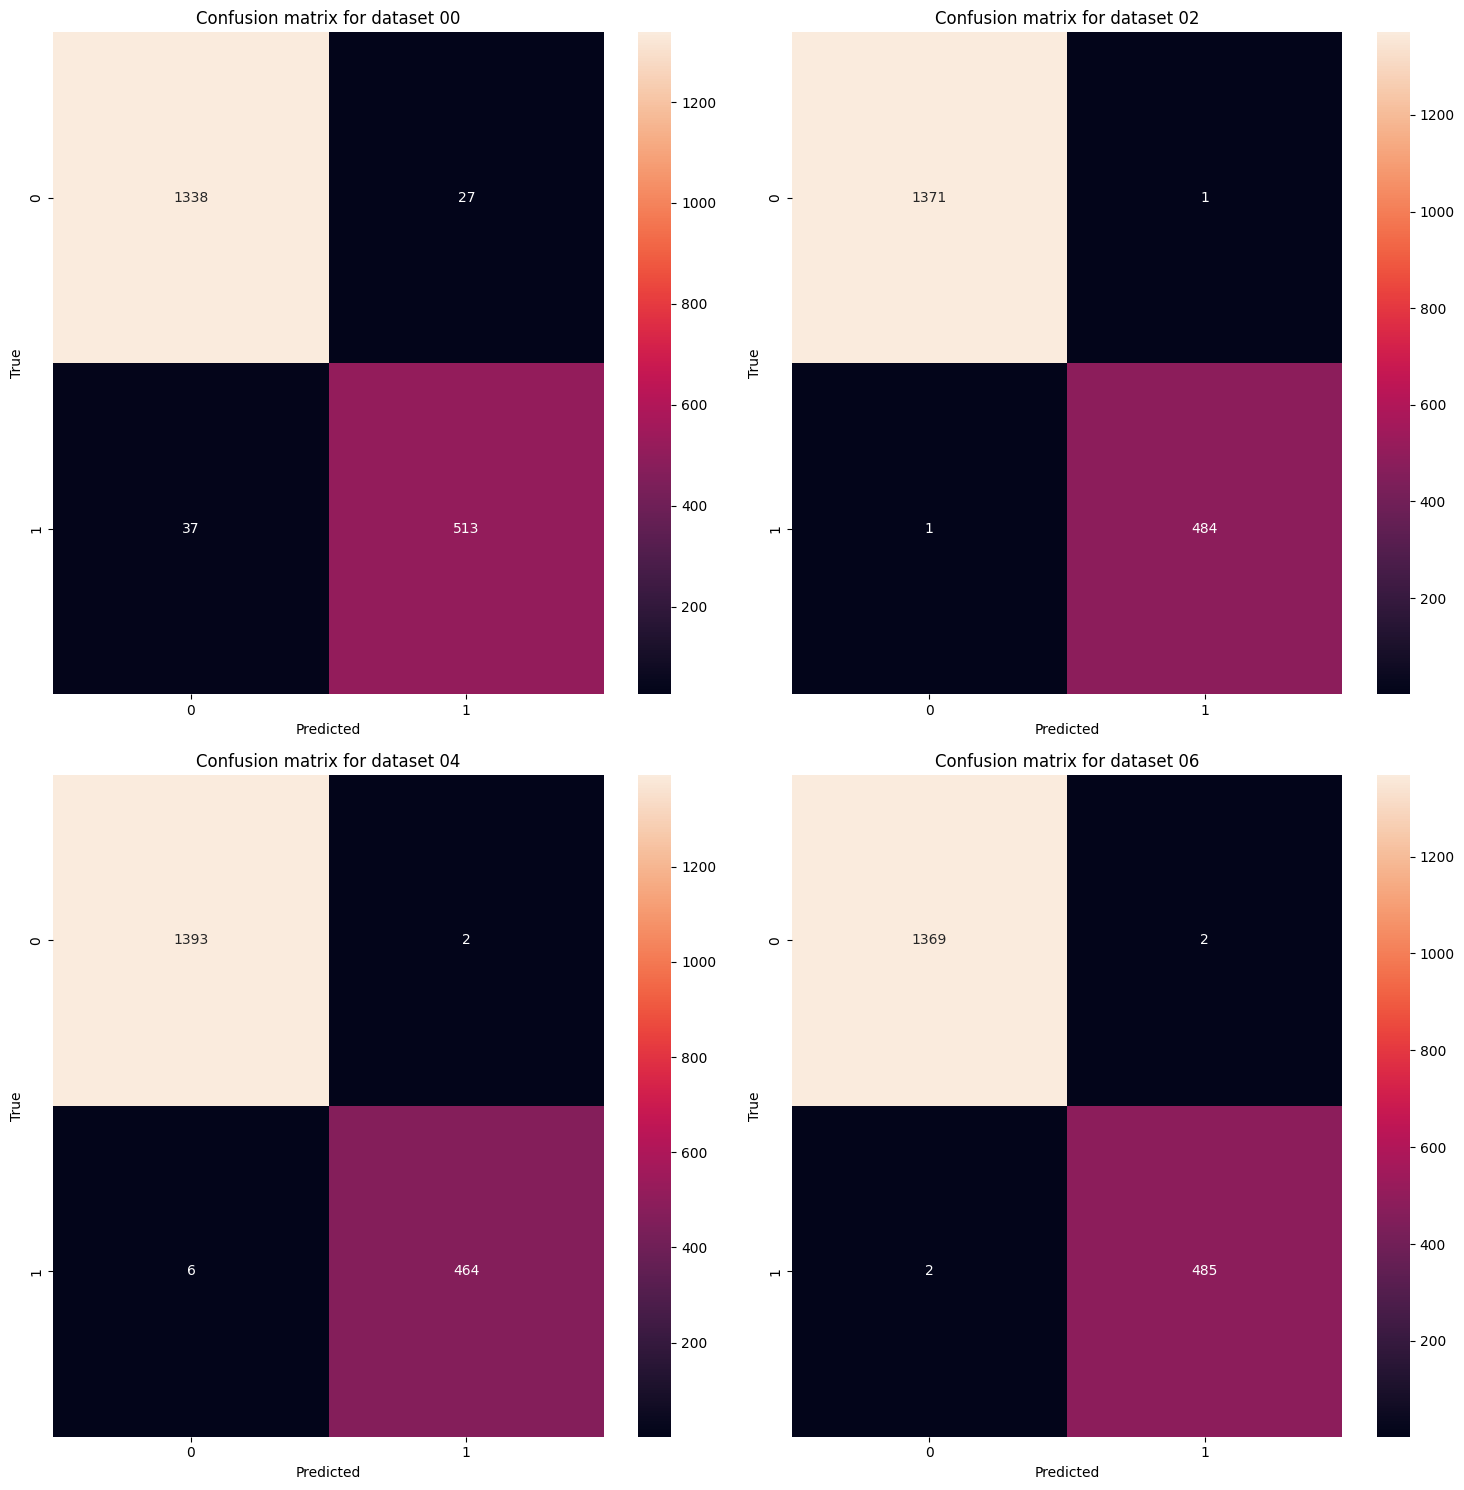

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix for the best models in a unique figure
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, key in enumerate(best_models):
    X, y = data[key]
    X_train, X_val, X_test, y_train, y_val, y_test = split_balanced(X, y)

    model = keras.models.load_model('models/{}.h5'.format(best_models[key]))

    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, ax=axes[i // 2][i % 2], fmt='g')
    axes[i // 2][i % 2].set_title('Confusion matrix for dataset {}'.format(key))
    axes[i // 2][i % 2].set_xlabel('Predicted')
    axes[i // 2][i % 2].set_ylabel('True')

fig.tight_layout()
plt.show()

## Now check the ability of these models to generalize

### Try to use the best models on the data of the other machines

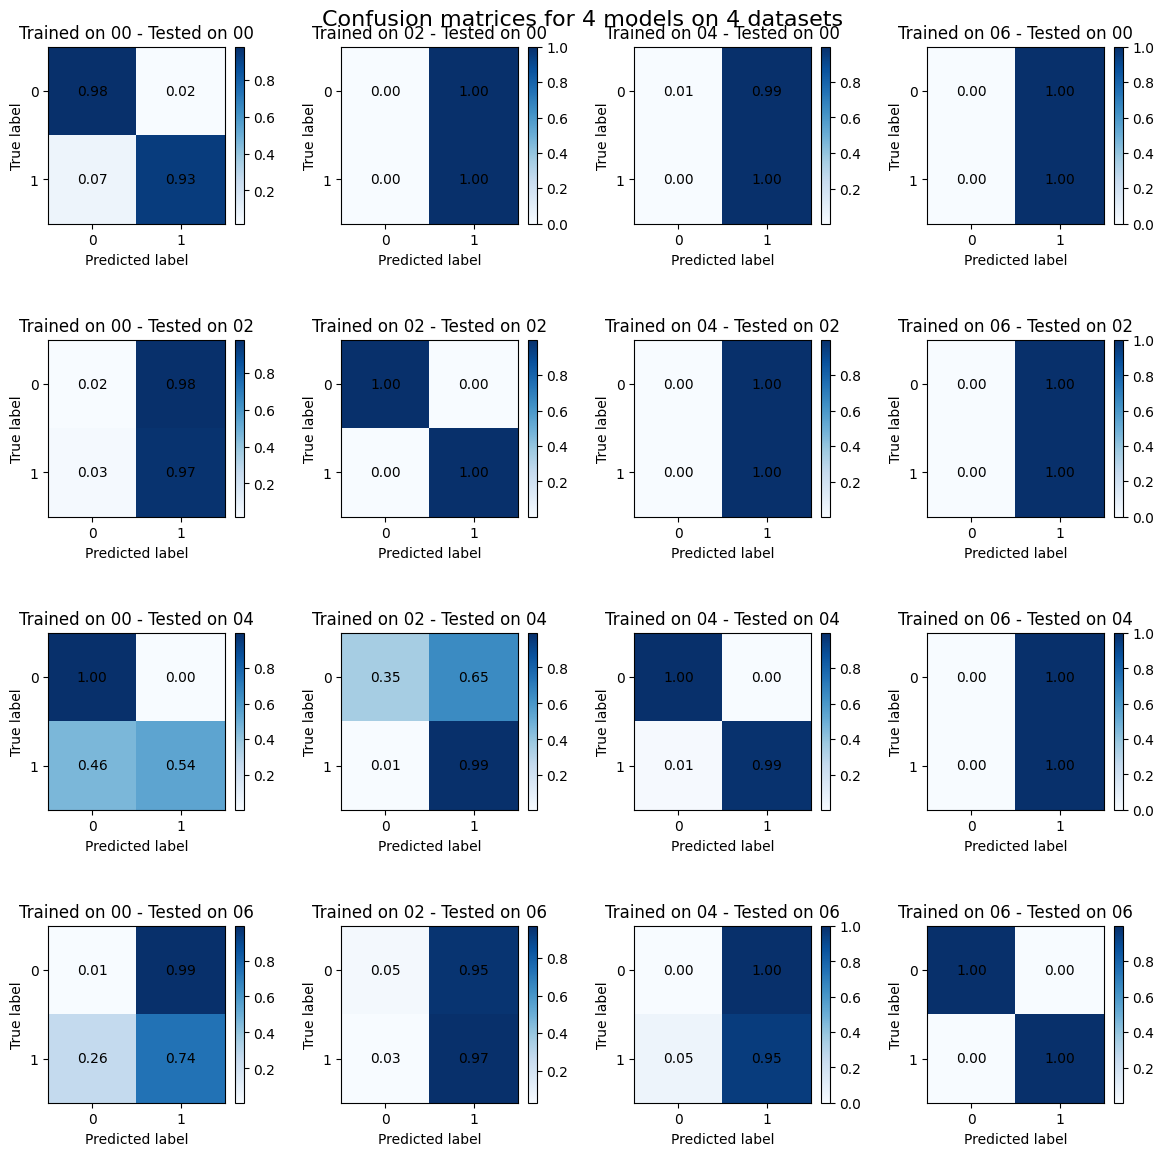

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a grid of subplots with 4 rows and 4 columns
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

# Loop over each dataset and model, and plot the confusion matrix in the corresponding subplot
for i, key in enumerate(data):
    for j, key2 in enumerate(data):
        # Get the dataset and model names
        X, y = data[key]

        # Split the data
        X_train, X_val, X_test, y_train, y_val, y_test = split_balanced(X, y)

        # Load the model
        model = keras.models.load_model('models/best/{}.h5'.format(key2))

        # Calculate the predictions
        y_pred_test = model.predict(X_test, verbose=0)
        y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

        # Generate a random confusion matrix as a placeholder
        cm = confusion_matrix(y_test, y_pred_test, normalize='true')

        # Plot the confusion matrix in the corresponding subplot
        im = axs[i, j].imshow(cm, cmap='Blues', extent=[-0.5, 1.5, 1.5, -0.5])
        axs[i, j].set_xticks(np.arange(2))
        axs[i, j].set_yticks(np.arange(2))
        axs[i, j].set_xlabel('Predicted label')
        axs[i, j].set_ylabel('True label')
        axs[i, j].set_title(f'Trained on {key2} - Tested on {key}')
        # Add text to show the numerical values of the confusion matrix
        for k in range(2):
            for l in range(2):
                text = axs[i, j].text(l, k, f'{cm[k, l]:.2f}', ha="center", va="center", color="black")

        # Add a colorbar for the current subplot
        divider = make_axes_locatable(axs[i, j])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(im, cax=cax)

# Add a shared colorbar for all subplots
# fig.colorbar(im, ax=axs, shrink=0.6)

# Adjust the spacing between subplots and add a main title
fig.tight_layout(pad=2)
fig.suptitle('Confusion matrices for 4 models on 4 datasets', fontsize=16)

# Show the plot
plt.show()

The models trained on a specific machine show a poor ability to generalize to other machines.